In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = True
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-10-22 10:47:00.465876: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-10-22 10:47:11.268194: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-10-22 10:47:11.294377: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-10-22 10:47:11.294408: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-10-22 10:47:11.296487: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-10-22 10:47:11.298753: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load data from the output of Brusselator model

In [2]:
import os

In [3]:
dataset = TINN_Single_Sim_Dataset(os.path.abspath("../../test/outputs_Brusselator/Brusselator_1"),
                                 "Brusselator_1",
                                 thining_start=-2)

In [4]:
dataset.x_size

32768

In [5]:
from turing.loss_functions import PDE_Parameter, Parameter_Type
#from turing.utils import Simulation

In [40]:
#layers = [5, 128, 128, 128, 128, 2]
layers = [3, 256, 256, 256, 256, 2]
#layers = [5, 512, 512, 512, 512, 2]

#lb = np.concatenate([lb, [0, 0]])
#ub = np.concatenate([ub, [2.0, 2.0]])
pinn = tu.NN(layers, dataset.lb, dataset.ub, dtype=tf.float64)
pde_loss = Brusselator(D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, dataset.simulation.Ds[0],dtype=pinn.dtype),
                       D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, dataset.simulation.Ds[1],dtype=pinn.dtype),
                       A=PDE_Parameter("A", Parameter_Type.CONSTANT, dataset.simulation.parameters["A"],dtype=pinn.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.VARIABLE, dataset.simulation.parameters["A"],dtype=pinn.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.INPUT, index=0),
                       B=PDE_Parameter("B", Parameter_Type.CONSTANT, dataset.simulation.parameters["B"],dtype=pinn.dtype)
                       #B=PDE_Parameter("B", Parameter_Type.INPUT, index=1)
                      )

l2_norm = L2()
l_inf_norm = L_Inf()

In [41]:
optimizer=keras.optimizers.Adam(learning_rate=5e-4)

In [42]:
model = tu.TINN(pinn, 
                pde_loss, 
                loss = l2_norm+ l_inf_norm,
                #non_zero_loss=pde_non_zero, 
                alpha = 0.9,
                loss_penalty_power=1,
                print_precision=".10f")

In [ ]:
results = model.train(epochs=15000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=200,
                      stop_threshold=1e-5,
                      optimizer=optimizer,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0
Training observations acc over epoch: 4.2501420975
total loss: 17.0007972008, total regularisd loss (sum of batches): 98.1562571488
obs u loss: 14.0842188761, obs v loss: 2.9163482680
pde u loss: 0.0002187879, pde v loss: 0.0000112688
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000

Time taken: 50.68s

Start of epoch 200
Training observations acc over epoch: 1.6369397640
total loss: 6.5477697936, total regularisd loss (sum of batches): 100.7144566068
obs u loss: 6.3318394877, obs v loss: 0.2159196338
pde u loss: 0.0000048767, pde v loss: 0.0000057954
lambda obs u: 3.9756830173, lambda obs v: 0.0189910315
lambda pde u: 0.0026386288, lambda pde v: 0.0026873223

Time taken: 529.59s

Start of epoch 400
Training observations acc over epoch: 1.6369810104
total loss: 6.5479345598, total regularisd loss (sum of batches): 100.6725476347
obs u loss: 6.3319419403, obs v loss: 0.2159821925
pde u loss: 0.0000047333, pde


Start of epoch 4400
Training observations acc over epoch: 0.0518485345
total loss: 0.2075086033, total regularisd loss (sum of batches): 4.2456238720
obs u loss: 0.1721819514, obs v loss: 0.0352121903
pde u loss: 0.0000568802, pde v loss: 0.0000575814
lambda obs u: 2.7026045638, lambda obs v: 0.9990907214
lambda pde u: 0.1154187981, lambda pde v: 0.1828859167

Time taken: 512.04s

Start of epoch 4600
Training observations acc over epoch: 0.0415592156
total loss: 0.1663244218, total regularisd loss (sum of batches): 3.7044200328
obs u loss: 0.1230587334, obs v loss: 0.0431781286
pde u loss: 0.0000440971, pde v loss: 0.0000434627
lambda obs u: 2.8753655847, lambda obs v: 0.7480880518
lambda pde u: 0.1594736766, lambda pde v: 0.2170726869

Time taken: 512.02s

Start of epoch 4800
Training observations acc over epoch: 0.0400784239
total loss: 0.1603818441, total regularisd loss (sum of batches): 3.5223984855
obs u loss: 0.1014764497, obs v loss: 0.0588372463
pde u loss: 0.0000348034, pde 


Start of epoch 8800
Training observations acc over epoch: 0.0326694623
total loss: 0.1307277091, total regularisd loss (sum of batches): 2.7286545681
obs u loss: 0.0782659279, obs v loss: 0.0524119293
pde u loss: 0.0000245576, pde v loss: 0.0000252943
lambda obs u: 2.8109409232, lambda obs v: 0.6690635419
lambda pde u: 0.2046127041, lambda pde v: 0.3153828309

Time taken: 511.76s

Start of epoch 9000
Training observations acc over epoch: 0.0231110919
total loss: 0.0924558137, total regularisd loss (sum of batches): 1.0035069562
obs u loss: 0.0262635327, obs v loss: 0.0661808289
pde u loss: 0.0000056613, pde v loss: 0.0000057908
lambda obs u: 2.4208297538, lambda obs v: 0.9151112687
lambda pde u: 0.3510232274, lambda pde v: 0.3130357500

Time taken: 511.77s

Start of epoch 9200
Training observations acc over epoch: 0.0207390785
total loss: 0.0829697355, total regularisd loss (sum of batches): 1.1507930908
obs u loss: 0.0295682613, obs v loss: 0.0533880508
pde u loss: 0.0000063246, pde 

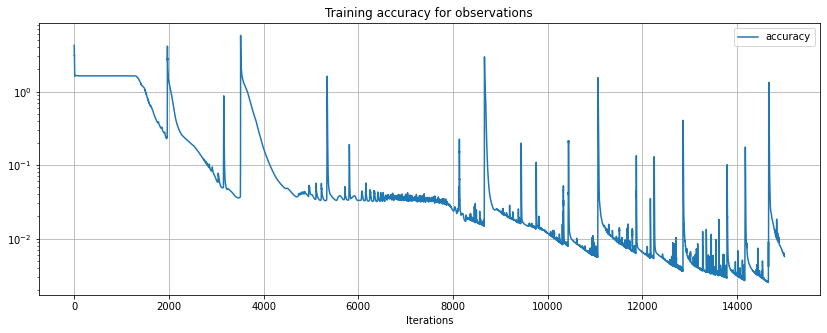

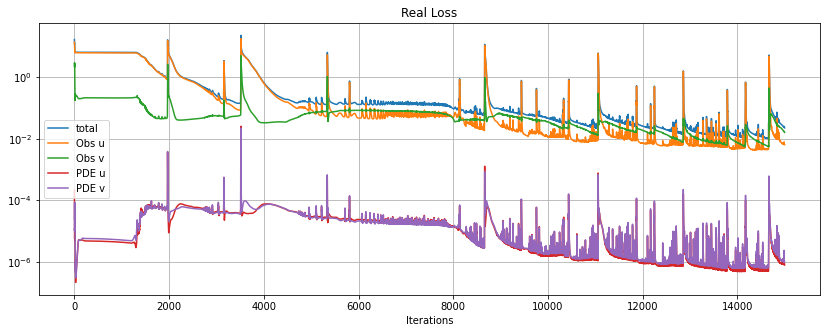

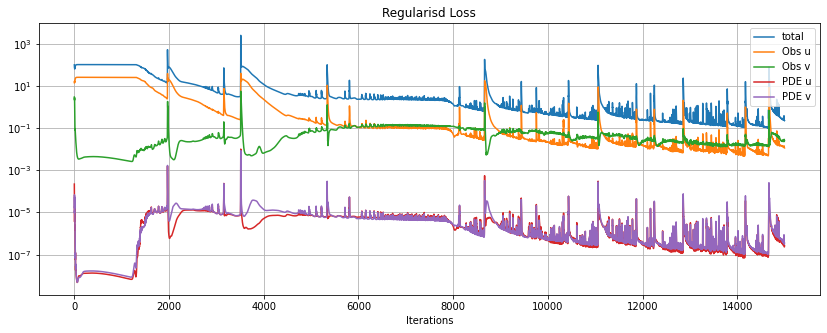

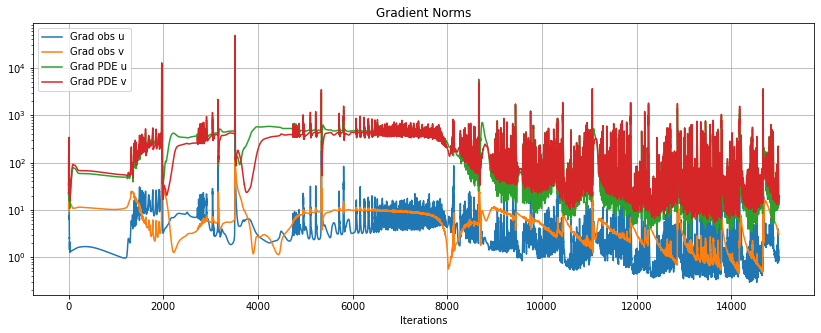

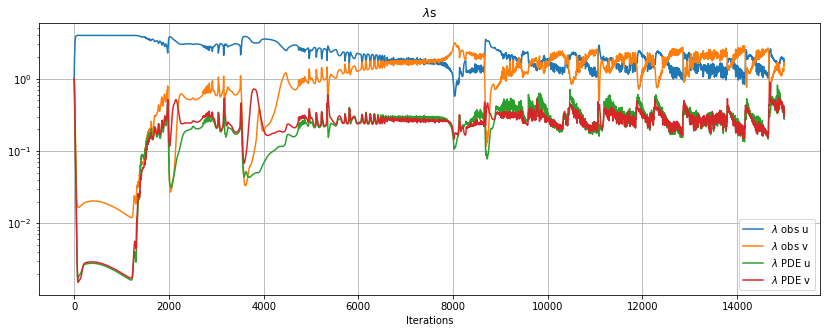

In [48]:
plot_result(results)

In [60]:
results = model.train(epochs=1000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=20,
                      stop_threshold=2e-3,
                      optimizer=optimizer,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0
Training observations acc over epoch: 0.0056509869
total loss: 0.0226057053, total regularisd loss (sum of batches): 0.2258427350
obs u loss: 0.0064423772, obs v loss: 0.0161615704
pde u loss: 0.0000007887, pde v loss: 0.0000009689
lambda obs u: 1.7636863440, lambda obs v: 1.5335442104
lambda pde u: 0.3384343529, lambda pde v: 0.3643350927

Time taken: 2.60s

Start of epoch 20
Training observations acc over epoch: 0.0054321233
total loss: 0.0217302593, total regularisd loss (sum of batches): 0.2332838239
obs u loss: 0.0069916315, obs v loss: 0.0147368615
pde u loss: 0.0000007971, pde v loss: 0.0000009691
lambda obs u: 1.3021194320, lambda obs v: 1.9520468835
lambda pde u: 0.3468141406, lambda pde v: 0.3990195439

Time taken: 50.47s

Start of epoch 40
Training observations acc over epoch: 0.0052422355
total loss: 0.0209706603, total regularisd loss (sum of batches): 0.2262639700
obs u loss: 0.0074116038, obs v loss: 0.0135573375
pde u loss: 0.0000007901, pde v loss: 0.


Start of epoch 440
Training observations acc over epoch: 0.0030163415
total loss: 0.0120665965, total regularisd loss (sum of batches): 0.1273720481
obs u loss: 0.0048057865, obs v loss: 0.0072595795
pde u loss: 0.0000005793, pde v loss: 0.0000006513
lambda obs u: 1.6165330650, lambda obs v: 1.8728580135
lambda pde u: 0.2533589366, lambda pde v: 0.2572499849

Time taken: 51.17s

Start of epoch 460
Training observations acc over epoch: 0.0029178006
total loss: 0.0116724013, total regularisd loss (sum of batches): 0.1191169491
obs u loss: 0.0048063842, obs v loss: 0.0068648173
pde u loss: 0.0000005522, pde v loss: 0.0000006476
lambda obs u: 1.4045020120, lambda obs v: 2.1742332174
lambda pde u: 0.2104719509, lambda pde v: 0.2107928196

Time taken: 51.19s

Start of epoch 480
Training observations acc over epoch: 0.0028488028
total loss: 0.0113963789, total regularisd loss (sum of batches): 0.1181725510
obs u loss: 0.0046839784, obs v loss: 0.0067112330
pde u loss: 0.0000005432, pde v los


Start of epoch 880
Training observations acc over epoch: 0.0028019589
total loss: 0.0112088863, total regularisd loss (sum of batches): 0.1122741847
obs u loss: 0.0044022240, obs v loss: 0.0068056114
pde u loss: 0.0000004858, pde v loss: 0.0000005650
lambda obs u: 1.6659557323, lambda obs v: 1.8453733919
lambda pde u: 0.2389089927, lambda pde v: 0.2497618830

Time taken: 51.17s

Start of epoch 900
Training observations acc over epoch: 0.0027306373
total loss: 0.0109236369, total regularisd loss (sum of batches): 0.1099702562
obs u loss: 0.0044740465, obs v loss: 0.0064485025
pde u loss: 0.0000004945, pde v loss: 0.0000005934
lambda obs u: 1.3234443099, lambda obs v: 2.2524657573
lambda pde u: 0.2165632142, lambda pde v: 0.2075267186

Time taken: 51.17s

Start of epoch 920
Training observations acc over epoch: 0.0026676168
total loss: 0.0106715565, total regularisd loss (sum of batches): 0.1084807610
obs u loss: 0.0044005572, obs v loss: 0.0062699099
pde u loss: 0.0000004976, pde v los

In [78]:
results = model.train(epochs=1000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=20,
                      stop_threshold=2e-3,
                      optimizer=optimizer,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0
Training observations acc over epoch: 0.0027566482
total loss: 0.0110275734, total regularisd loss (sum of batches): 0.1094809408
obs u loss: 0.0041251045, obs v loss: 0.0069014884
pde u loss: 0.0000004562, pde v loss: 0.0000005243
lambda obs u: 1.8190584839, lambda obs v: 1.6557379658
lambda pde u: 0.2613192446, lambda pde v: 0.2638843057

Time taken: 2.55s

Start of epoch 20
Training observations acc over epoch: 0.0026815629
total loss: 0.0107272203, total regularisd loss (sum of batches): 0.1067707617
obs u loss: 0.0040869131, obs v loss: 0.0066393386
pde u loss: 0.0000004506, pde v loss: 0.0000005181
lambda obs u: 1.7892761976, lambda obs v: 1.6899782822
lambda pde u: 0.2593433880, lambda pde v: 0.2614021322

Time taken: 50.04s

Start of epoch 40
Training observations acc over epoch: 0.0026069512
total loss: 0.0104287752, total regularisd loss (sum of batches): 0.1051668948
obs u loss: 0.0040251671, obs v loss: 0.0064026380
pde u loss: 0.0000004496, pde v loss: 0.

In [89]:
model.save("/end/home/rh2310/save_tests", "model_128_by_128_1")

In [90]:
import pickle
symbolic_weights = getattr(optimizer, 'weights')
weight_values = tf.keras.backend.batch_get_value(symbolic_weights)
with open('/end/home/rh2310/save_tests/optimizer_128_by_128_1.pkl', 'wb') as f:
    pickle.dump(weight_values, f)

In [ ]:
with open('/end/home/rh2310/save_tests/optimizer_128_by_128_1.pkl', 'rb') as f:
    weight_values = pickle.load(f)
    
optimizer=keras.optimizers.Adam(learning_rate=5e-4)    
optimizer.set_weights(weight_values)

In [77]:
model.alpha.assign(0.95)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=0.95>

In [79]:
x_domain = dataset.simulation.L[0] * np.linspace(0, 1, dataset.simulation.n[0])
y_domain = dataset.simulation.L[1] * np.linspace(0, 1, dataset.simulation.n[1])
x_size = dataset.simulation.n[0]
y_size = dataset.simulation.n[1]
N2 = x_size * y_size


T_test_index = -1#119
print(dataset.ts[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(dataset.ts[T_test_index], N2)  # 1 x N2

A_test = np.repeat(dataset.simulation.parameters["A"]+1, N2)
B_test = np.repeat(dataset.simulation.parameters["B"]+1, N2)

2048.0


In [80]:
#output_test = pinn(np.vstack([XX_test, YY_test, TT_test, A_test, B_test]).T)
output_test = pinn(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

In [81]:
import os
data_path = os.path.abspath("../../test/outputs_Brusselator/Brusselator_1/Brusselator_1.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data = data[...,-2:]

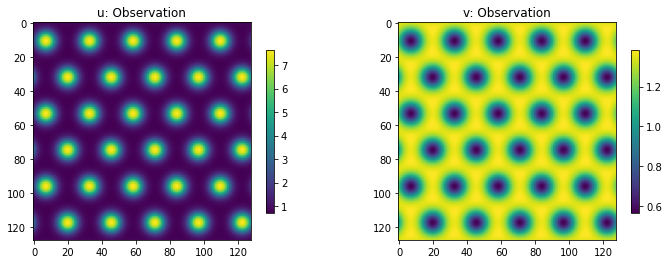

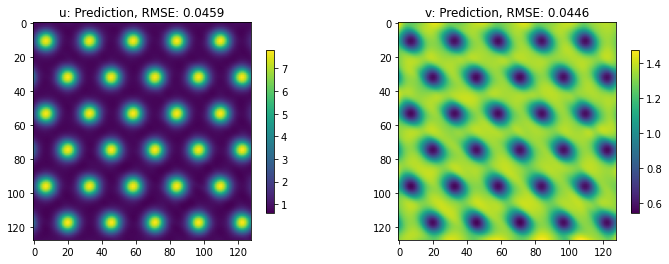

In [82]:
node_names = ["u", "v"]
_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data[i,:, :, T_test_index])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    rmse = np.sqrt(np.mean((output_test[i,:, :] - data[i,:, :, T_test_index])**2))
    plt.title(f"{name}: Prediction, RMSE: {rmse:.4f}")
    
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [83]:
#test_d = np.vstack([XX_test, YY_test, TT_test, A_test, B_test]).T
test_d = np.vstack([XX_test, YY_test, TT_test]).T
test_outputs = np.zeros((test_d.shape[0], len(node_names)))
test_pde_u = np.zeros(test_d.shape[0])
test_pde_v = np.zeros(test_d.shape[0])

for i, _ in enumerate(test_d):
    outs, pde_u, pde_v = pde_loss.residual(pinn, test_d[i:(i+1), ...])
    test_outputs[i] = outs.numpy()
    test_pde_u[i] = pde_u.numpy()
    test_pde_v[i] = pde_v.numpy()


In [84]:
test_outputs = np.array([ test_outputs[:, i].reshape((x_size, y_size)) for i in range(test_outputs.shape[1])]) 
test_pde_u = test_pde_u.reshape((x_size, y_size))
test_pde_v = test_pde_v.reshape((x_size, y_size))

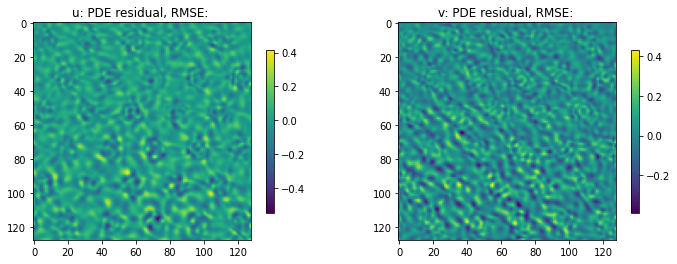

In [85]:
_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.title(f"u: PDE residual, RMSE: ")
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
plt.title(f"v: PDE residual, RMSE: ")
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)

plt.show()

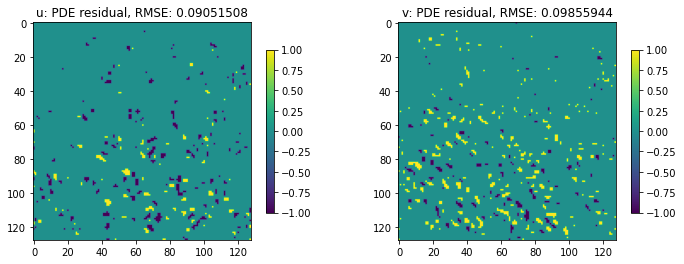

In [88]:
max_L = .19
min_L = -.19

_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)

d = test_pde_u.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"u: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
d = test_pde_v.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"v: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)

plt.colorbar(shrink=.75)

plt.show()

# Examples on how to use parameters as input

In [3]:
import os
data_path = os.path.abspath("../../test/outputs_Brusselator_32_by_32/Brusselator_1/Brusselator_1.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)

In [4]:
data_path = os.path.abspath("../../test/outputs_Brusselator_32_by_32/Brusselator_1/simulation.txt")
with open(data_path, 'r') as f:
    #t_star = np.load(f) 
    simulation = eval(f.read())

In [5]:

t_star = np.linspace(simulation.t_start, simulation.t_end, simulation.t_steps)    

    
# Thining the dataset
#t_star = t_star[::16]
#data = data[...,::16]

t_star = t_star[-2:]
data = data[...,-2:]

T = t_star.shape[0]    
    
L = simulation.L[0]
x_size = simulation.n[0]#data.shape[1]
y_size = simulation.n[1]#data.shape[2]
N = x_size*y_size

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']


In [6]:
t_star.shape

(2,)

In [7]:
np.concatenate([lb, [0]])

array([  0.        ,   0.        , 254.99607843,   0.        ])

In [8]:
from turing.loss_functions import PDE_Parameter, Parameter_Type

In [9]:
#layers = [5, 128, 128, 128, 128, 2]
layers = [3, 256, 256, 256, 256, 2]
#layers = [5, 512, 512, 512, 512, 2]

#lb = np.concatenate([lb, [0, 0]])
#ub = np.concatenate([ub, [2.0, 2.0]])
pinn = tu.NN(layers, lb, ub, dtype=tf.float64)
pde_loss = Brusselator(D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0],dtype=pinn.dtype),
                       D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, simulation.Ds[1],dtype=pinn.dtype),
                       A=PDE_Parameter("A", Parameter_Type.CONSTANT, simulation.parameters["A"],dtype=pinn.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.VARIABLE, simulation.parameters["A"],dtype=pinn.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.INPUT, index=0),
                       B=PDE_Parameter("B", Parameter_Type.CONSTANT, simulation.parameters["B"],dtype=pinn.dtype)
                       #B=PDE_Parameter("B", Parameter_Type.INPUT, index=1)
                      )

l2_norm = L2()
l_inf_norm = L_Inf()

In [10]:
obs_X.shape

(2048, 3)

In [11]:
obs_X2 = np.concatenate([obs_X, 
                         np.repeat(simulation.parameters["A"]+1, obs_X.shape[0])[..., np.newaxis],
                        np.repeat(simulation.parameters["B"]+1, obs_X.shape[0])[..., np.newaxis]], axis=1)

In [12]:
obs_X2.shape

(2048, 5)

In [13]:
obs_X2[0]

array([  1.93548387,   1.61290323, 256.        ,   3.        ,
         4.        ])

In [14]:
model = tu.TINN(pinn, 
                pde_loss, 
                loss = l2_norm+ l_inf_norm,
                #non_zero_loss=pde_non_zero, 
                #optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
                alpha = 0.9,
                loss_penalty_power=1,
                print_precision=".10f")

In [15]:
pde_loss._trainables_

()

In [16]:
optimizer=keras.optimizers.Adam(learning_rate=1e-4)

In [17]:
results = model.train(epochs=30000+1,
                      batch_size=len(obs_X),
                      X=obs_X,
                      Y=obs_Y,
                      print_interval=100,
                      stop_threshold=1e-5,
                      optimizer=optimizer,
                      shuffle=True,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0


2022-10-17 10:31:19.521224: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-10-17 10:31:29.388338: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 4.6968665123
total loss: 26.4411796249, total regularisd loss (sum of batches): 26.4411796249
obs u loss: 15.8871795546, obs v loss: 2.9002866877
pde u loss: 7.4737732708, pde v loss: 0.1799401118
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000

Time taken: 15.18s

Start of epoch 100
Training observations acc over epoch: 2.0558824539
total loss: 8.6714317080, total regularisd loss (sum of batches): 29.8323891772
obs u loss: 7.8870478162, obs v loss: 0.3364822410
pde u loss: 0.1823600502, pde v loss: 0.2655416006
lambda obs u: 3.7868224780, lambda obs v: 0.1201746765
lambda pde u: 0.0484407172, lambda pde v: 0.0445621283

Time taken: 27.84s

Start of epoch 200
Training observations acc over epoch: 2.0349485874
total loss: 8.2487111627, total regularisd loss (sum of batches): 31.3706302502
obs u loss: 7.8443752249, obs v loss: 0.2954185915
pde u loss: 0.0158635034, pde v loss: 0.0930538430


Start of epoch 2200
Training observations acc over epoch: 2.0081872940
total loss: 10.8273135572, total regularisd loss (sum of batches): 31.2142928907
obs u loss: 7.8050368537, obs v loss: 0.2277123442
pde u loss: 1.3702919869, pde v loss: 1.4242723724
lambda obs u: 3.9991706519, lambda obs v: 0.0004546157
lambda pde u: 0.0002115517, lambda pde v: 0.0001631807

Time taken: 20.03s

Start of epoch 2300
Training observations acc over epoch: 2.0115182400
total loss: 10.8251641894, total regularisd loss (sum of batches): 31.2045590374
obs u loss: 7.8025843040, obs v loss: 0.2434888199
pde u loss: 1.3497735610, pde v loss: 1.4293175046
lambda obs u: 3.9991758976, lambda obs v: 0.0004364850
lambda pde u: 0.0002228407, lambda pde v: 0.0001647767

Time taken: 20.06s

Start of epoch 2400
Training observations acc over epoch: 2.0139594078
total loss: 10.7562846896, total regularisd loss (sum of batches): 31.1889467048
obs u loss: 7.7989543027, obs v loss: 0.2568831841
pde u loss: 1.3346082780, 


Start of epoch 4400
Training observations acc over epoch: 1.9899388552
total loss: 11.4658528843, total regularisd loss (sum of batches): 30.7432892277
obs u loss: 7.7077360617, obs v loss: 0.2520196775
pde u loss: 2.1550237258, pde v loss: 1.3510734194
lambda obs u: 3.9863875696, lambda obs v: 0.0034108001
lambda pde u: 0.0082805491, lambda pde v: 0.0019210812

Time taken: 20.03s

Start of epoch 4500
Training observations acc over epoch: 1.9872863293
total loss: 12.7252414231, total regularisd loss (sum of batches): 30.7329326634
obs u loss: 7.6939561607, obs v loss: 0.2551893477
pde u loss: 3.0269880179, pde v loss: 1.7491078967
lambda obs u: 3.9917888851, lambda obs v: 0.0013342854
lambda pde u: 0.0061516663, lambda pde v: 0.0007251631

Time taken: 20.02s

Start of epoch 4600
Training observations acc over epoch: 1.9833248854
total loss: 13.3684616531, total regularisd loss (sum of batches): 30.6782430875
obs u loss: 7.6808445105, obs v loss: 0.2524551179
pde u loss: 3.4572223015, 


Start of epoch 6600
Training observations acc over epoch: 1.8346824646
total loss: 14.7103296224, total regularisd loss (sum of batches): 28.4341277947
obs u loss: 7.1483786070, obs v loss: 0.1903510114
pde u loss: 5.9508404046, pde v loss: 1.4207595994
lambda obs u: 3.9469098357, lambda obs v: 0.0090871772
lambda pde u: 0.0343295447, lambda pde v: 0.0096734424

Time taken: 20.00s

Start of epoch 6700
Training observations acc over epoch: 1.8233993053
total loss: 15.9742380072, total regularisd loss (sum of batches): 28.2229916604
obs u loss: 7.0918144408, obs v loss: 0.2017831066
pde u loss: 6.8938205377, pde v loss: 1.7868199220
lambda obs u: 3.9334064250, lambda obs v: 0.0113930127
lambda pde u: 0.0444372534, lambda pde v: 0.0107633088

Time taken: 20.01s

Start of epoch 6800
Training observations acc over epoch: 1.8141391277
total loss: 16.2097770009, total regularisd loss (sum of batches): 28.0305641833
obs u loss: 7.0431965183, obs v loss: 0.2133598690
pde u loss: 6.9668915634, 


Start of epoch 8800
Training observations acc over epoch: 1.5679448843
total loss: 12.6218477426, total regularisd loss (sum of batches): 21.7543196363
obs u loss: 6.0489553627, obs v loss: 0.2228243101
pde u loss: 3.6824230318, pde v loss: 2.6676450380
lambda obs u: 3.3423689307, lambda obs v: 0.1781221940
lambda pde u: 0.3179371033, lambda pde v: 0.1615717721

Time taken: 20.11s

Start of epoch 8900
Training observations acc over epoch: 1.5377597809
total loss: 13.9703053536, total regularisd loss (sum of batches): 23.5680035691
obs u loss: 5.9244609039, obs v loss: 0.2265784586
pde u loss: 5.2975849141, pde v loss: 2.5216810771
lambda obs u: 3.9396585328, lambda obs v: 0.0113547215
lambda pde u: 0.0366979341, lambda pde v: 0.0122888115

Time taken: 20.07s

Start of epoch 9000
Training observations acc over epoch: 1.5222226381
total loss: 15.6393810732, total regularisd loss (sum of batches): 23.3342384283
obs u loss: 5.8536265904, obs v loss: 0.2352640550
pde u loss: 6.4528844834, 


Start of epoch 11000
Training observations acc over epoch: 1.2511030436
total loss: 18.8057566505, total regularisd loss (sum of batches): 19.1255170487
obs u loss: 4.7565768343, obs v loss: 0.2478354812
pde u loss: 8.1490976374, pde v loss: 5.6522466976
lambda obs u: 3.9068362583, lambda obs v: 0.0224277715
lambda pde u: 0.0548593032, lambda pde v: 0.0158766670

Time taken: 20.02s

Start of epoch 11100
Training observations acc over epoch: 1.2392961979
total loss: 19.3367481150, total regularisd loss (sum of batches): 18.9491964248
obs u loss: 4.7065302000, obs v loss: 0.2506544496
pde u loss: 8.4073938633, pde v loss: 5.9721696021
lambda obs u: 3.9047271243, lambda obs v: 0.0231692224
lambda pde u: 0.0554575675, lambda pde v: 0.0166460858

Time taken: 20.01s

Start of epoch 11200
Training observations acc over epoch: 1.2269523144
total loss: 19.7484825538, total regularisd loss (sum of batches): 18.7645087152
obs u loss: 4.6553713336, obs v loss: 0.2524378146
pde u loss: 8.609324610

Time taken: 20.05s

Start of epoch 13200
Training observations acc over epoch: 0.9945614934
total loss: 19.3052563856, total regularisd loss (sum of batches): 15.1676588688
obs u loss: 3.7266888304, obs v loss: 0.2515573077
pde u loss: 8.5127323590, pde v loss: 6.8142778886
lambda obs u: 3.8647870926, lambda obs v: 0.0414456293
lambda pde u: 0.0679594096, lambda pde v: 0.0258078684

Time taken: 20.09s

Start of epoch 13300
Training observations acc over epoch: 1.0128272772
total loss: 13.8811630329, total regularisd loss (sum of batches): 14.8834554532
obs u loss: 3.8851888024, obs v loss: 0.1661203026
pde u loss: 5.7548332499, pde v loss: 4.0750206780
lambda obs u: 3.0909689528, lambda obs v: 0.3441211578
lambda pde u: 0.3238083722, lambda pde v: 0.2411015172

Time taken: 20.09s

Start of epoch 13400
Training observations acc over epoch: 0.9913185835
total loss: 15.0223855143, total regularisd loss (sum of batches): 15.1142071466
obs u loss: 3.7697703858, obs v loss: 0.1955040142
pde 

Time taken: 20.02s

Start of epoch 15400
Training observations acc over epoch: 0.8741710782
total loss: 17.7637482923, total regularisd loss (sum of batches): 13.3250356200
obs u loss: 3.2670119677, obs v loss: 0.2296721405
pde u loss: 7.8453045886, pde v loss: 6.4217595956
lambda obs u: 3.8405613694, lambda obs v: 0.0560943817
lambda pde u: 0.0711889582, lambda pde v: 0.0321552908

Time taken: 20.15s

Start of epoch 15500
Training observations acc over epoch: 0.8658221960
total loss: 17.6470344240, total regularisd loss (sum of batches): 13.1927200325
obs u loss: 3.2338848560, obs v loss: 0.2294037525
pde u loss: 7.7894138285, pde v loss: 6.3943319870
lambda obs u: 3.8380391639, lambda obs v: 0.0575126695
lambda pde u: 0.0715859517, lambda pde v: 0.0328622149

Time taken: 20.14s

Start of epoch 15600
Training observations acc over epoch: 0.8570883870
total loss: 17.5259589026, total regularisd loss (sum of batches): 13.0540415545
obs u loss: 3.1992514225, obs v loss: 0.2291021460
pde 


Start of epoch 17600
Training observations acc over epoch: 0.7335197330
total loss: 15.5950223793, total regularisd loss (sum of batches): 11.1295550971
obs u loss: 2.7223412407, obs v loss: 0.2117375792
pde u loss: 6.9406194805, pde v loss: 5.7203240789
lambda obs u: 3.8090700085, lambda obs v: 0.0767885652
lambda pde u: 0.0743851365, lambda pde v: 0.0397562899

Time taken: 20.06s

Start of epoch 17700
Training observations acc over epoch: 0.7262312770
total loss: 15.5075873723, total regularisd loss (sum of batches): 11.0162180292
obs u loss: 2.6938008123, obs v loss: 0.2111242447
pde u loss: 6.9079302542, pde v loss: 5.6947320611
lambda obs u: 3.8075627062, lambda obs v: 0.0778271205
lambda pde u: 0.0744183097, lambda pde v: 0.0401918636

Time taken: 20.02s

Start of epoch 17800
Training observations acc over epoch: 0.7186311483
total loss: 15.4165402091, total regularisd loss (sum of batches): 10.8980344412
obs u loss: 2.6640929861, obs v loss: 0.2104316637
pde u loss: 6.873990397

Time taken: 20.11s

Start of epoch 19800
Training observations acc over epoch: 0.6432699561
total loss: 14.3812524045, total regularisd loss (sum of batches): 9.7627583758
obs u loss: 2.3838071060, obs v loss: 0.1892725785
pde u loss: 6.4605996915, pde v loss: 5.3475730285
lambda obs u: 3.7987082594, lambda obs v: 0.0872085443
lambda pde u: 0.0725887708, lambda pde v: 0.0414944255

Time taken: 20.12s

Start of epoch 19900
Training observations acc over epoch: 0.6385379434
total loss: 14.3448169563, total regularisd loss (sum of batches): 9.6906829297
obs u loss: 2.3652537497, obs v loss: 0.1888982826
pde u loss: 6.4474253498, pde v loss: 5.3432395741
lambda obs u: 3.7976447718, lambda obs v: 0.0879112303
lambda pde u: 0.0726107986, lambda pde v: 0.0418331993

Time taken: 20.10s

Start of epoch 20000
Training observations acc over epoch: 0.6336057186
total loss: 14.3035069389, total regularisd loss (sum of batches): 9.6153630491
obs u loss: 2.3459613712, obs v loss: 0.1884615567
pde u l


Start of epoch 22000
Training observations acc over epoch: 0.5445857644
total loss: 13.0517733613, total regularisd loss (sum of batches): 8.2443837972
obs u loss: 2.0058917614, obs v loss: 0.1724515865
pde u loss: 5.8824632244, pde v loss: 4.9909667890
lambda obs u: 3.7780689119, lambda obs v: 0.1050395780
lambda pde u: 0.0723065849, lambda pde v: 0.0445849251

Time taken: 20.00s

Start of epoch 22100
Training observations acc over epoch: 0.5394352674
total loss: 12.9932792691, total regularisd loss (sum of batches): 8.1651514637
obs u loss: 1.9858549881, obs v loss: 0.1718862794
pde u loss: 5.8557952895, pde v loss: 4.9797427121
lambda obs u: 3.7763114492, lambda obs v: 0.1063697443
lambda pde u: 0.0724065866, lambda pde v: 0.0449122199

Time taken: 19.99s

Start of epoch 22200
Training observations acc over epoch: 0.5340906382
total loss: 12.9272247458, total regularisd loss (sum of batches): 8.0826003154
obs u loss: 1.9650969142, obs v loss: 0.1712658097
pde u loss: 5.8255324328, 


Start of epoch 24200
Training observations acc over epoch: 0.4803687036
total loss: 11.8325705012, total regularisd loss (sum of batches): 7.2444416595
obs u loss: 1.7631562210, obs v loss: 0.1583185489
pde u loss: 5.3106611585, pde v loss: 4.6004345728
lambda obs u: 3.7461075450, lambda obs v: 0.1308405232
lambda pde u: 0.0741323683, lambda pde v: 0.0489195635

Time taken: 20.01s

Start of epoch 24300
Training observations acc over epoch: 0.4763455987
total loss: 11.7571353001, total regularisd loss (sum of batches): 7.1805145168
obs u loss: 1.7474349263, obs v loss: 0.1579473530
pde u loss: 5.2754577244, pde v loss: 4.5762952965
lambda obs u: 3.7432036665, lambda obs v: 0.1330059181
lambda pde u: 0.0743566238, lambda pde v: 0.0494337916

Time taken: 20.00s

Start of epoch 24400
Training observations acc over epoch: 0.4721610546
total loss: 11.6742919243, total regularisd loss (sum of batches): 7.1137643272
obs u loss: 1.7311102509, obs v loss: 0.1575339465
pde u loss: 5.2367860625, 


Start of epoch 26400
Training observations acc over epoch: 0.4278271198
total loss: 9.0676411046, total regularisd loss (sum of batches): 6.3346693077
obs u loss: 1.5795051385, obs v loss: 0.1318033215
pde u loss: 4.0506906387, pde v loss: 3.3056420059
lambda obs u: 3.6862249520, lambda obs v: 0.1828695731
lambda pde u: 0.0743829652, lambda pde v: 0.0565225096

Time taken: 20.00s

Start of epoch 26500
Training observations acc over epoch: 0.4256874621
total loss: 9.2330111355, total regularisd loss (sum of batches): 6.3086645221
obs u loss: 1.5695536228, obs v loss: 0.1331960830
pde u loss: 4.1120699124, pde v loss: 3.4181915172
lambda obs u: 3.6955384594, lambda obs v: 0.1777078466
lambda pde u: 0.0740512082, lambda pde v: 0.0527024858

Time taken: 20.03s

Start of epoch 26600
Training observations acc over epoch: 0.4239564538
total loss: 9.3587417790, total regularisd loss (sum of batches): 6.2875705596
obs u loss: 1.5615229912, obs v loss: 0.1343029280
pde u loss: 4.1623378952, pde


Start of epoch 28600
Training observations acc over epoch: 0.3923180401
total loss: 9.5034257151, total regularisd loss (sum of batches): 5.8255531550
obs u loss: 1.4285852552, obs v loss: 0.1406870494
pde u loss: 4.2163110532, pde v loss: 3.7178423573
lambda obs u: 3.6707501543, lambda obs v: 0.1906071381
lambda pde u: 0.0788498508, lambda pde v: 0.0597928568

Time taken: 19.98s

Start of epoch 28700
Training observations acc over epoch: 0.3901215792
total loss: 9.4576952961, total regularisd loss (sum of batches): 5.7901581974
obs u loss: 1.4197058316, obs v loss: 0.1407805726
pde u loss: 4.1947434730, pde v loss: 3.7024654189
lambda obs u: 3.6688264006, lambda obs v: 0.1919191482
lambda pde u: 0.0790171210, lambda pde v: 0.0602373303

Time taken: 19.99s

Start of epoch 28800
Training observations acc over epoch: 0.3878329694
total loss: 9.4085371628, total regularisd loss (sum of batches): 5.7531581566
obs u loss: 1.4104592959, obs v loss: 0.1408725690
pde u loss: 4.1715820094, pde

In [26]:
results2 = model.train(epochs=30000+1,
                      batch_size=len(obs_X),
                      X=obs_X,
                      Y=obs_Y,
                      print_interval=100,
                      stop_threshold=1e-5,
                      optimizer=optimizer,
                      shuffle=True,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0
Training observations acc over epoch: 3.3883247375
total loss: 20.5542654500, total regularisd loss (sum of batches): 49.4030283061
obs u loss: 13.3273142739, obs v loss: 0.2259848222
pde u loss: 3.7110690988, pde v loss: 3.2898972550
lambda obs u: 3.6674897482, lambda obs v: 0.1961574667
lambda pde u: 0.0767491277, lambda pde v: 0.0596036574

Time taken: 0.31s

Start of epoch 100
Training observations acc over epoch: 1.7808853388
total loss: 23.1317386360, total regularisd loss (sum of batches): 26.6236587413
obs u loss: 6.9161697814, obs v loss: 0.2073705243
pde u loss: 8.7423407011, pde v loss: 7.2658576292
lambda obs u: 3.4409583653, lambda obs v: 0.2188139832
lambda pde u: 0.2100351352, lambda pde v: 0.1301925163

Time taken: 19.49s

Start of epoch 200
Training observations acc over epoch: 1.5023974180
total loss: 20.8814067610, total regularisd loss (sum of batches): 22.7170954385
obs u loss: 5.8226887115, obs v loss: 0.1869015649
pde u loss: 8.5671502909, pde v


Start of epoch 2200
Training observations acc over epoch: 0.7841112018
total loss: 14.2033749018, total regularisd loss (sum of batches): 12.0929868492
obs u loss: 2.9836914318, obs v loss: 0.1527531656
pde u loss: 6.2379673725, pde v loss: 4.8289629319
lambda obs u: 3.7623460038, lambda obs v: 0.0897237845
lambda pde u: 0.0988241568, lambda pde v: 0.0491060549

Time taken: 19.98s

Start of epoch 2300
Training observations acc over epoch: 0.7755751610
total loss: 14.2783536665, total regularisd loss (sum of batches): 11.9683724628
obs u loss: 2.9488096865, obs v loss: 0.1534910717
pde u loss: 6.2774965996, pde v loss: 4.8985563087
lambda obs u: 3.7598675664, lambda obs v: 0.0910182658
lambda pde u: 0.0992177950, lambda pde v: 0.0498963728

Time taken: 19.97s

Start of epoch 2400
Training observations acc over epoch: 0.7670274377
total loss: 14.3237404696, total regularisd loss (sum of batches): 11.8412030935
obs u loss: 2.9137881219, obs v loss: 0.1543213252
pde u loss: 6.3034808912, 


Start of epoch 4400
Training observations acc over epoch: 0.6128660440
total loss: 10.9525624858, total regularisd loss (sum of batches): 9.1684714146
obs u loss: 2.2659243792, obs v loss: 0.1855396432
pde u loss: 4.7460660393, pde v loss: 3.7550324242
lambda obs u: 3.7552966855, lambda obs v: 0.0960707341
lambda pde u: 0.0840491560, lambda pde v: 0.0645834244

Time taken: 19.97s

Start of epoch 4500
Training observations acc over epoch: 0.6071206331
total loss: 11.1726893659, total regularisd loss (sum of batches): 9.1048953272
obs u loss: 2.2446338551, obs v loss: 0.1838486093
pde u loss: 4.8520058774, pde v loss: 3.8922010241
lambda obs u: 3.7572583085, lambda obs v: 0.0961685796
lambda pde u: 0.0865219932, lambda pde v: 0.0600511186

Time taken: 19.96s

Start of epoch 4600
Training observations acc over epoch: 0.6022965908
total loss: 11.3466699670, total regularisd loss (sum of batches): 9.0490382499
obs u loss: 2.2264008945, obs v loss: 0.1827856252
pde u loss: 4.9307902908, pde

Time taken: 20.09s

Start of epoch 6600
Training observations acc over epoch: 0.5172423720
total loss: 11.6626424960, total regularisd loss (sum of batches): 7.7732244819
obs u loss: 1.8742278050, obs v loss: 0.1947417056
pde u loss: 5.0621093082, pde v loss: 4.5315636773
lambda obs u: 3.7394929729, lambda obs v: 0.1072570751
lambda pde u: 0.0927625297, lambda pde v: 0.0604874224

Time taken: 20.06s

Start of epoch 6700
Training observations acc over epoch: 0.5119972825
total loss: 11.5952949885, total regularisd loss (sum of batches): 7.6860461540
obs u loss: 1.8518868688, obs v loss: 0.1961022556
pde u loss: 5.0286391035, pde v loss: 4.5186667606
lambda obs u: 3.7380999470, lambda obs v: 0.1081035205
lambda pde u: 0.0928558390, lambda pde v: 0.0609406935

Time taken: 20.04s

Start of epoch 6800
Training observations acc over epoch: 0.5066174269
total loss: 11.5213185792, total regularisd loss (sum of batches): 7.5961033094
obs u loss: 1.8289370911, obs v loss: 0.1975327621
pde u loss


Start of epoch 8800
Training observations acc over epoch: 0.4144248366
total loss: 9.3687682224, total regularisd loss (sum of batches): 5.9546653997
obs u loss: 1.4260871161, obs v loss: 0.2316122129
pde u loss: 3.9697224427, pde v loss: 3.7413464507
lambda obs u: 3.7060700679, lambda obs v: 0.1287831467
lambda pde u: 0.0954687450, lambda pde v: 0.0696780404

Time taken: 19.96s

Start of epoch 8900
Training observations acc over epoch: 0.4096899927
total loss: 9.2784371996, total regularisd loss (sum of batches): 5.8725943619
obs u loss: 1.4051244082, obs v loss: 0.2336353992
pde u loss: 3.9268906479, pde v loss: 3.7127867443
lambda obs u: 3.7031533222, lambda obs v: 0.1303341451
lambda pde u: 0.0959362955, lambda pde v: 0.0705762372

Time taken: 19.96s

Start of epoch 9000
Training observations acc over epoch: 0.4048422873
total loss: 9.1796418629, total regularisd loss (sum of batches): 5.7876370178
obs u loss: 1.3836063435, obs v loss: 0.2357628815
pde u loss: 3.8802431227, pde v 


Start of epoch 11000
Training observations acc over epoch: 0.3609157205
total loss: 8.0383354955, total regularisd loss (sum of batches): 4.9766970989
obs u loss: 1.1853406617, obs v loss: 0.2583222171
pde u loss: 3.3531234576, pde v loss: 3.2415491591
lambda obs u: 3.6817448217, lambda obs v: 0.1441350852
lambda pde u: 0.0979915489, lambda pde v: 0.0761285443

Time taken: 19.97s

Start of epoch 11100
Training observations acc over epoch: 0.3580296040
total loss: 7.9820070645, total regularisd loss (sum of batches): 4.9258824496
obs u loss: 1.1722893923, obs v loss: 0.2598290242
pde u loss: 3.3265617280, pde v loss: 3.2233269200
lambda obs u: 3.6795887001, lambda obs v: 0.1452977156
lambda pde u: 0.0983065327, lambda pde v: 0.0768070515

Time taken: 19.96s

Start of epoch 11200
Training observations acc over epoch: 0.3550644219
total loss: 7.9205624613, total regularisd loss (sum of batches): 4.8731814319
obs u loss: 1.1588409656, obs v loss: 0.2614167794
pde u loss: 3.2976713482, pde


Start of epoch 13200
Training observations acc over epoch: 0.3247698843
total loss: 6.8620654054, total regularisd loss (sum of batches): 4.2771736886
obs u loss: 1.0184772012, obs v loss: 0.2806023365
pde u loss: 2.8140972460, pde v loss: 2.7488886217
lambda obs u: 3.6590753682, lambda obs v: 0.1592668444
lambda pde u: 0.0989392671, lambda pde v: 0.0827185202

Time taken: 19.99s

Start of epoch 13300
Training observations acc over epoch: 0.3232559562
total loss: 6.8488745219, total regularisd loss (sum of batches): 4.2529359492
obs u loss: 1.0117216023, obs v loss: 0.2813020916
pde u loss: 2.8073048647, pde v loss: 2.7485459633
lambda obs u: 3.6573515812, lambda obs v: 0.1600587582
lambda pde u: 0.0994607763, lambda pde v: 0.0831288843

Time taken: 19.99s

Start of epoch 13400
Training observations acc over epoch: 0.3217137754
total loss: 6.8313277097, total regularisd loss (sum of batches): 4.2277259898
obs u loss: 1.0047948245, obs v loss: 0.2820602843
pde u loss: 2.7984031474, pde


Start of epoch 15400
Training observations acc over epoch: 0.2959917486
total loss: 5.7687773386, total regularisd loss (sum of batches): 3.6912607627
obs u loss: 0.8799334030, obs v loss: 0.3040335834
pde u loss: 2.3126131194, pde v loss: 2.2721972328
lambda obs u: 3.6254458195, lambda obs v: 0.1798620520
lambda pde u: 0.1002350876, lambda pde v: 0.0944570409

Time taken: 19.99s

Start of epoch 15500
Training observations acc over epoch: 0.2945099473
total loss: 5.7812885156, total regularisd loss (sum of batches): 3.6706207070
obs u loss: 0.8735661192, obs v loss: 0.3044737298
pde u loss: 2.3179154364, pde v loss: 2.2853332302
lambda obs u: 3.6242171029, lambda obs v: 0.1804515196
lambda pde u: 0.1011226687, lambda pde v: 0.0942087088

Time taken: 20.01s

Start of epoch 15600
Training observations acc over epoch: 0.2930665910
total loss: 5.7856487807, total regularisd loss (sum of batches): 3.6496814256
obs u loss: 0.8672584565, obs v loss: 0.3050078956
pde u loss: 2.3188860494, pde

Time taken: 20.00s

Start of epoch 17600
Training observations acc over epoch: 0.2854974270
total loss: 4.7084276922, total regularisd loss (sum of batches): 3.3799069749
obs u loss: 0.8158845278, obs v loss: 0.3261051219
pde u loss: 1.7475298978, pde v loss: 1.8189081448
lambda obs u: 3.5612116225, lambda obs v: 0.2121680858
lambda pde u: 0.0993137152, lambda pde v: 0.1273065765

Time taken: 20.01s

Start of epoch 17700
Training observations acc over epoch: 0.2842125893
total loss: 4.7529154038, total regularisd loss (sum of batches): 3.3603145708
obs u loss: 0.8105495196, obs v loss: 0.3263008481
pde u loss: 1.7830544552, pde v loss: 1.8330105809
lambda obs u: 3.5735635318, lambda obs v: 0.2077935137
lambda pde u: 0.0973564497, lambda pde v: 0.1212865048

Time taken: 20.00s

Start of epoch 17800
Training observations acc over epoch: 0.2830566764
total loss: 4.7910509197, total regularisd loss (sum of batches): 3.3436573514
obs u loss: 0.8058479617, obs v loss: 0.3263788809
pde u loss


Start of epoch 19800
Training observations acc over epoch: 0.2666663527
total loss: 4.9660694448, total regularisd loss (sum of batches): 3.1245795550
obs u loss: 0.7373643757, obs v loss: 0.3293010605
pde u loss: 1.9196268148, pde v loss: 1.9797771938
lambda obs u: 3.5778009537, lambda obs v: 0.2077421796
lambda pde u: 0.1086590486, lambda pde v: 0.1057978181

Time taken: 19.98s

Start of epoch 19900
Training observations acc over epoch: 0.2658395767
total loss: 4.9531475375, total regularisd loss (sum of batches): 3.1114877974
obs u loss: 0.7335666872, obs v loss: 0.3297915920
pde u loss: 1.9124599560, pde v loss: 1.9773293023
lambda obs u: 3.5752509935, lambda obs v: 0.2087693252
lambda pde u: 0.1093893356, lambda pde v: 0.1065903457

Time taken: 20.00s

Start of epoch 20000
Training observations acc over epoch: 0.2649969757
total loss: 4.9381829468, total regularisd loss (sum of batches): 3.0978500859
obs u loss: 0.7296600757, obs v loss: 0.3303278121
pde u loss: 1.9043232336, pde


Start of epoch 22000
Training observations acc over epoch: 0.2473393083
total loss: 4.2131803798, total regularisd loss (sum of batches): 2.7329090363
obs u loss: 0.6436247103, obs v loss: 0.3457325576
pde u loss: 1.5526040262, pde v loss: 1.6712190856
lambda obs u: 3.5307673745, lambda obs v: 0.2340939538
lambda pde u: 0.1135349125, lambda pde v: 0.1216037592

Time taken: 19.98s

Start of epoch 22100
Training observations acc over epoch: 0.2460801899
total loss: 4.2037457536, total regularisd loss (sum of batches): 2.7143508708
obs u loss: 0.6379821099, obs v loss: 0.3463386235
pde u loss: 1.5464801720, pde v loss: 1.6729448482
lambda obs u: 3.5262425956, lambda obs v: 0.2361838754
lambda pde u: 0.1151106552, lambda pde v: 0.1224628737

Time taken: 20.00s

Start of epoch 22200
Training observations acc over epoch: 0.2448678613
total loss: 4.1869191757, total regularisd loss (sum of batches): 2.6953604260
obs u loss: 0.6323962327, obs v loss: 0.3470751817
pde u loss: 1.5367231878, pde


Start of epoch 24200
Training observations acc over epoch: 0.2276481539
total loss: 3.5813972631, total regularisd loss (sum of batches): 2.3665745686
obs u loss: 0.5512336810, obs v loss: 0.3593589022
pde u loss: 1.2373475427, pde v loss: 1.4334571372
lambda obs u: 3.4510912367, lambda obs v: 0.2771574573
lambda pde u: 0.1269768671, lambda pde v: 0.1447744390

Time taken: 20.02s

Start of epoch 24300
Training observations acc over epoch: 0.2266739756
total loss: 3.5475155791, total regularisd loss (sum of batches): 2.3483102333
obs u loss: 0.5463217777, obs v loss: 0.3603740441
pde u loss: 1.2196732376, pde v loss: 1.4211465198
lambda obs u: 3.4431501696, lambda obs v: 0.2811382271
lambda pde u: 0.1284290332, lambda pde v: 0.1472825701

Time taken: 20.05s

Start of epoch 24400
Training observations acc over epoch: 0.2256790102
total loss: 3.5109319957, total regularisd loss (sum of batches): 2.3292078745
obs u loss: 0.5412843253, obs v loss: 0.3614316837
pde u loss: 1.2008153144, pde


Start of epoch 26400
Training observations acc over epoch: 0.2201601863
total loss: 3.2420621688, total regularisd loss (sum of batches): 2.1942412397
obs u loss: 0.5122711810, obs v loss: 0.3683695051
pde u loss: 1.0760922050, pde v loss: 1.2853292777
lambda obs u: 3.4267408805, lambda obs v: 0.2961834957
lambda pde u: 0.1261407583, lambda pde v: 0.1509348655

Time taken: 20.00s

Start of epoch 26500
Training observations acc over epoch: 0.2196171582
total loss: 3.2288505969, total regularisd loss (sum of batches): 2.1865434185
obs u loss: 0.5096965542, obs v loss: 0.3687719869
pde u loss: 1.0679234941, pde v loss: 1.2824585617
lambda obs u: 3.4188315171, lambda obs v: 0.2997042669
lambda pde u: 0.1281236636, lambda pde v: 0.1533405524

Time taken: 19.97s

Start of epoch 26600
Training observations acc over epoch: 0.2190795243
total loss: 3.2135472784, total regularisd loss (sum of batches): 2.1784874475
obs u loss: 0.5070908106, obs v loss: 0.3692273128
pde u loss: 1.0588129909, pde


Start of epoch 28600
Training observations acc over epoch: 0.2063752413
total loss: 2.6690987044, total regularisd loss (sum of batches): 1.9380889252
obs u loss: 0.4511869492, obs v loss: 0.3743140267
pde u loss: 0.7825149459, pde v loss: 1.0610827826
lambda obs u: 3.3038794936, lambda obs v: 0.3658695478
lambda pde u: 0.1432737785, lambda pde v: 0.1869771801

Time taken: 19.99s

Start of epoch 28700
Training observations acc over epoch: 0.2055769861
total loss: 2.6428650869, total regularisd loss (sum of batches): 1.9260055288
obs u loss: 0.4474432942, obs v loss: 0.3748647011
pde u loss: 0.7681445573, pde v loss: 1.0524125344
lambda obs u: 3.2859051086, lambda obs v: 0.3746803960
lambda pde u: 0.1473056040, lambda pde v: 0.1921088915

Time taken: 19.98s

Start of epoch 28800
Training observations acc over epoch: 0.2773243487
total loss: 6.2900341083, total regularisd loss (sum of batches): 3.1802416034
obs u loss: 0.7462032162, obs v loss: 0.3630942700
pde u loss: 2.6441551552, pde

In [50]:
dataset.ts

array([2044.79499218, 2048.        ])

In [99]:
model.save("/end/home/rh2310/save_tests", "model_32_by_32_1")

In [3]:
model2 = tu.TINN_inverse.restore("/end/home/rh2310/save_tests", "model_1")

In [5]:
pinn2 = model2.pinn
pde_residual2 = model2.pde_residual
pde_non_zero2 = model2.non_zero_loss

In [6]:
l2_norm = L2()
l_inf_norm = L_Inf()

In [7]:
model2 = tu.TINN_inverse(pinn2, 
                pde_residual2, 
                loss = l2_norm + l_inf_norm,
                non_zero_loss=pde_non_zero2, 
                #optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
                alpha = 0.5,
                print_precision=".10f")

In [8]:
results2 = model2.train(epochs=2,
                      batch_size=len(obs_X)//8,
                      X=obs_X,
                      Y=obs_Y,
                      print_interval=50,
                      stop_threshold=1e-5,
                      shuffle=True,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0
Training observations acc over epoch: 9.1382770538
total loss: 40.1722202250, total regularisd loss (sum of batches): 321.3777617996
obs u loss: 35.1095967489, obs v loss: 1.4435098442
pde u loss: 1.1400859622, pde v loss: 2.4790276697
pde params loss: 3.6191136319
Non-zero loss: 0.0000002037, 
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000
lambda pde params u: 1.0000000000, lambda pde params v: 1.0000000000
D_u: 0.97075 D_v: 0.98211 sigma_u: 1.00919 sigma_v: 1.00798 
mu_u: 0.98492 rho_u: 1.01631 rho_v: 0.98552 kappa_u: 1.00232 

Time taken: 30.61s
